In [1]:
from typing import Optional, Union, Dict, List, Tuple

import time
import numpy as np
import pandas as pd
import seaborn as sns
from uuid import uuid4
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# Import data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aybatov/toxic-russian-comments-from-pikabu-and-2ch")
print("Path to dataset files:", path)

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/aybatov/toxic-russian-comments-from-pikabu-and-2ch/versions/1


In [3]:
import os

dataset_filename = 'russian_comments_from_2ch_pikabu.csv'
df = pd.read_csv(os.path.join(path, dataset_filename))
df.head()

,comment,toxic,translated
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"Camels, for what? Morons, bl ..."
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"Ukrainians, this is an outlet vent zatyukanog..."
2,Собаке - собачья смерть\n,1.0,Dog - Dog Death
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"Refresh the page, moron. This is also not an ..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,did not convince you of the 6-page pdf that S...


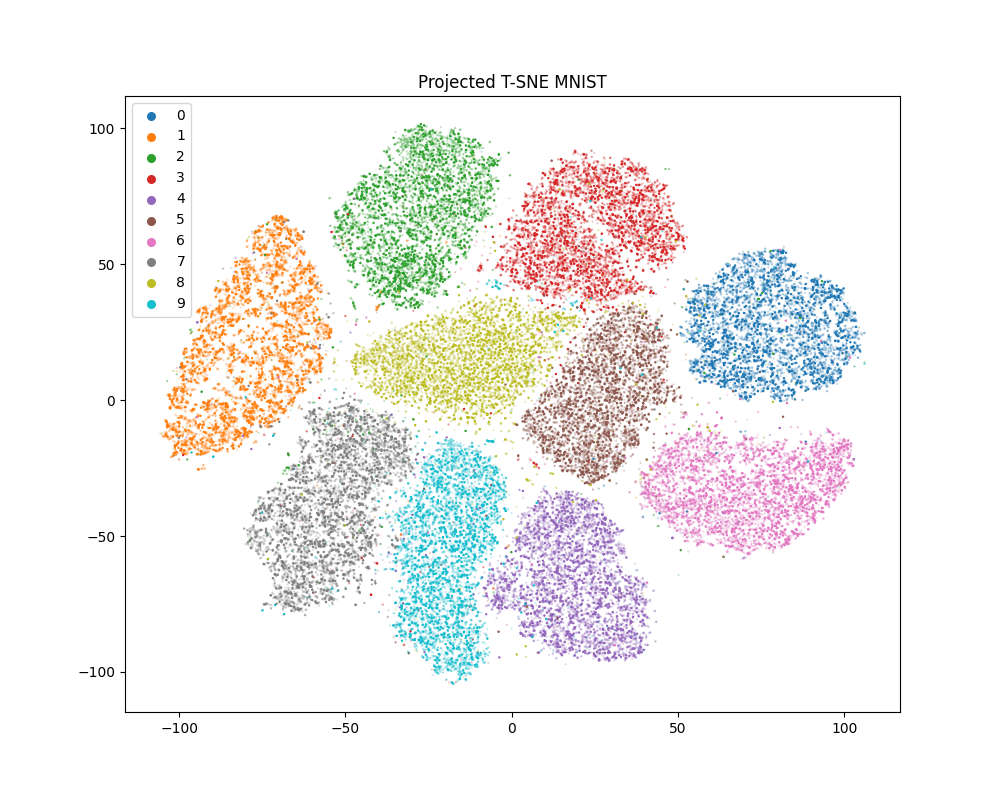

In [6]:
import PIL
PIL.Image.open("MNIST_projected_data_TSNE.png")

# Preprocess data

In [4]:
# Фиксим баг с deprecated вызовом метода в pymorphy2 перед импортом
bug_file = '/opt/conda/lib/python3.12/site-packages/pymorphy2/units/base.py'
with open(bug_file, 'r') as f:
    bug_text = f.read()

bug_text = bug_text.replace(
    'args, varargs, kw, default = inspect.getargspec', 
    'args, varargs, kw, default, _, _, _ = inspect.getfullargspec'
)

with open(bug_file, 'w') as f:
    f.write(bug_text)

In [5]:
import re
import nltk
import pymorphy2
from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
# Text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^а-яёa-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


df["clean"] = df["comment"].astype(str).apply(clean_text)

In [7]:
# Tokenization + Lemmatization
morph = pymorphy2.MorphAnalyzer()

def tokenize(text):
    tokens = nltk.word_tokenize(text, language="russian")
    lemmas = [morph.parse(t)[0].normal_form for t in tokens if t.strip()]
    return lemmas

df["tokens"] = df["clean"].apply(tokenize)
# Remove empty samples
df = df[df["tokens"].map(len) > 0]

In [8]:
# Create vocabulary
all_tokens = df["tokens"].tolist()
word_counts = {}

for sent in all_tokens:
    for w in sent:
        word_counts[w] = word_counts.get(w, 0) + 1

print("Full vocab size:", len(word_counts))

# Minimum frequency to keep the token
min_freq = 2

special_vocab = ["<PAD>", "<UNK>"]
vocab = special_vocab + [w for w, c in word_counts.items() if c >= min_freq]
word2idx = {w: i for i, w in enumerate(vocab)}

vocab_size = len(vocab)
print("Cleared vocab size:", vocab_size)

Full vocab size: 35167
Cleared vocab size: 16928


In [9]:
# Word2Vec embeddings
embedding_dim = 128

w2v = Word2Vec(
    sentences=all_tokens,
    vector_size=embedding_dim,
    window=5,
    min_count=min_freq,
    workers=4,
    sg=1
)

# embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
not_found_num = 0

for word, idx in word2idx.items():
    if word in w2v.wv:
        embedding_matrix[idx] = w2v.wv[word]
    elif word != "<PAD>":
        embedding_matrix[idx] = np.random.normal(scale=0.05, size=embedding_dim)
        if word != "<UNK>":
            not_found_num += 1

print(f"Not found and randomized: {not_found_num}")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Not found and randomized: 0


In [10]:
# Tokens to index sequences
def encode(tokens):
    return [word2idx.get(t, word2idx["<UNK>"]) for t in tokens]

df["ids"] = df["tokens"].apply(encode)

In [11]:
lens_mean = round(df["ids"].apply(len).mean())
lens_std = round(df["ids"].apply(len).std())

print(f"Mean: {lens_mean}, std {lens_std}")

max_len = lens_mean + 2 * lens_std
print("Max len:", max_len)

Mean: 28, std 41
Max len: 110


In [12]:
# Padding sequences
def pad(seq):
    if len(seq) >= max_len:
        return seq[:max_len]
    return seq + [word2idx["<PAD>"]] * (max_len - len(seq))

df["padded"] = df["ids"].apply(pad)

In [13]:
X = np.vstack(df["padded"].values)
X = embedding_matrix[X]
y = df["toxic"].astype(int).values

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (14412, 110, 128)
y shape: (14412,)


In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

In [15]:
print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (9728, 110, 128)
Val shape: (1081, 110, 128)
Test shape: (3603, 110, 128)


In [16]:
# Free memory
import gc

del df
del X
del y

gc.collect()

0

In [17]:
%reset Out

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Flushing output cache (2 entries)


# Modeling

## Common (utils)

In [18]:
def get_object(types_dict: Dict[str, type], obj: Union[str, object], base_type: type, default: str):
    if obj is None or isinstance(obj, str):
        obj = obj or default
        return types_dict[obj.lower()]()
    elif isinstance(obj, base_type):
        return obj
    else:
        raise RuntimeError(f"Param should be an instance of base {base_type}, string or None")

## Activation functions

In [19]:
# Base abstract Activation class

class Activation:
    NAME = None

    def call(self, x):
        raise NotImplementedError("Call not impelemted")

    def derivative(self, out, *args, **kwargs):
        raise NotImplementedError("Derivative not impelemted")

    def __call__(self, x):
        return self.call(x)

    def __str__(self):
        return self.NAME

In [20]:
class Linear(Activation):
    NAME = "linear"

    def call(self, x):
        return x

    def derivative(self, out, *args, **kwargs):
        return 1

In [21]:
class Sigmoid(Activation):
    NAME = "sigmoid"

    def __init__(self, clip_limit: Optional[Union[int, float]] = 250):
        self.clip_limit = -clip_limit if clip_limit is not None and clip_limit < 0 else clip_limit

    def call(self, x):
        x = np.clip(x, -self.clip_limit, self.clip_limit) if self.clip_limit else x
        return 1 / (1 + np.exp(-x))

    def derivative(self, out, *args, **kwargs):
        return out * (1 - out)

In [22]:
class Tanh(Activation):
    NAME = "tanh"

    # @njit(cache=True,fastmath=True)
    def call(self, x):
        return np.tanh(x)

    def derivative(self, out, *args, **kwargs):
        return 1. - out**2

In [23]:
class ReLU(Activation):
    NAME = 'relu'
    
    def call(self, x):
        return np.maximum(0, x)
    
    def derivative(self, out, *args, **kwargs):
        return (out > 0).astype(float)

In [24]:
class SiLU(Activation):
    NAME = "silu"
    
    def __init__(self, clip_limit: Optional[Union[int, float]] = 250):
        self.sigmoid = Sigmoid(clip_limit)
        self.x_sigm = None    # bhee

    def call(self, x):
        self.x_sigm = self.sigmoid(x)
        return x * self.x_sigm

    def derivative(self, out, *args, **kwargs):
        return self.x_sigm * (1. - out) + out

In [25]:
class StableSoftmax(Activation):
    """More numerically stable softmax implementation"""
    NAME = 'stable_softmax'

    def call(self, x):
        stable_x = x - np.max(x, axis=-1, keepdims=True)
        exp_x = np.exp(stable_x)
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

    def derivative(self, out, *args, **kwargs):
        if len(args) > 0:
            dout = args[0]
        elif 'dout' in kwargs:
            dout = kwargs['dout']
        else:
            raise ValueError("dout should be also provided for softmax derivative")
        dx = out * (dout - np.sum(dout * out, axis=-1, keepdims=True))
        return dx

In [26]:
# Find all classes based on Activation class
ACTIVATIONS = {
    v.NAME: v 
    for v in globals().values() 
    if isinstance(v, type) and Activation in v.__bases__
}

print(ACTIVATIONS)

{'linear': <class '__main__.Linear'>, 'sigmoid': <class '__main__.Sigmoid'>, 'tanh': <class '__main__.Tanh'>, 'relu': <class '__main__.ReLU'>, 'silu': <class '__main__.SiLU'>, 'stable_softmax': <class '__main__.StableSoftmax'>}


## Layers

### Base Layer

In [27]:
class BaseLayer:
    def __init__(self, input_size, output_size, activation='linear'):
        self.input_size = input_size
        self.output_size = output_size
        self.activation = get_object(ACTIVATIONS, activation, base_type=Activation, default='linear')
        # Train params
        self.weights = None
        self.bias = None
        self.init_weights()
        
        self.name = str(uuid4())
        self.training = True

    def enable_training(self):
        self.training = True

    def disable_training(self):
        self.training = False
    
    def init_weights(self):
        raise NotImplementedError("Init weights not impelemted")

    @property
    def num_params(self):
        raise NotImplementedError("Number of parameters not impelemted")

    def forward(self, X):
        raise NotImplementedError("Forward not impelemted")

    def __call__(self, *args, **kwargs):
        output = self.forward(*args, **kwargs)
        if not self.training:
            self.clear_tmp()
        return output

    def backward(self, X, output, doutput, calc_grads: bool = True):
        raise NotImplementedError("Backward not impelemted")

    def clear_tmp(self):
        pass

In [28]:
class LayersBlock:
    """ Class for Block of layers """
    def __init__(self):
        self.layers_names: list[str] = []
        self.layers: list[BaseLayer] = []
        
        self._block_input = None
        self._layers_outputs: list[np.ndarray] = []
        self._layers_grads: list[tuple[BaseLayer, np.ndarray]] = []
        
        self.name = str(uuid4())
        self.training = True

    def enable_training(self):
        self.training = True
        for l in self.layers:
            l.enable_training()

    def disable_training(self):
        self.training = False
        for l in self.layers:
            l.disable_training()
    
    def add_layer(self, layer: BaseLayer, name: str = None):
        name = name or layer.name
        self.layers_names.append(name)
        self.layers.append(layer)

    @property
    def num_params(self):
        return sum([l.num_params for l in self.layers])

    def _forward_layer(self, layer_name: str, X):
        if self.training and self._block_input is None:
            self._block_input = X

        layer_idx = self.layers_names.index(layer_name)
        output = self.layers[layer_idx].forward(X)
        self._layers_outputs.append(output)

        return output

    def _backward_layer(self, layer_name: str, doutput, calc_grads=True):
        layer_idx = self.layers_names.index(layer_name)
        layer_input = self._layers_outputs[layer_idx - 1] if layer_idx > 0 else self._block_input
        layer_output = self._layers_outputs[layer_idx]

        dinput, grads = self.layers[layer_idx].backward(layer_input, layer_output, doutput, calc_grads=calc_grads)
        
        if calc_grads:
            self._layers_grads.append((self.layers[layer_idx], grads))
        
        return dinput

    def forward(self, X):
        raise NotImplementedError("Forward not impelemted")

    def __call__(self, *args, **kwargs):
        output = self.forward(*args, **kwargs)
        if not self.training:
            self.clear_tmp()
        return output

    def backward(self, X, output, doutput, calc_grads: bool = True):
        raise NotImplementedError("Backward not impelemted")

    def clear_tmp(self):
        self._block_input = None
        self._layers_outputs = []
        self._layers_grads = []

    def summary(self, with_name: bool = False, return_array: bool = False):
        # Collect info
        info = [ # Header
            ["Layer", "Input size", "Output size", "Num params", "Activation"]
        ]
        if with_name:
            info[0].append("Unique Name")
        info_len = list(map(len, info[0]))
    
        total_params = 0
        for layer in self.layers:
            total_params += layer.num_params
            layer_info = (
                layer.__class__.__name__, 
                layer.input_size,
                layer.output_size,
                layer.num_params,
                layer.activation,
            )
            if with_name:
                layer_info += (layer.name)

            layer_info = list(map(str, layer_info))
            info.append(layer_info)
            
            layer_lens = list(map(len, layer_info))
            info_len = [max(_prev, _new) for _prev, _new in zip(info_len, layer_lens)]

        if return_array:
            return info
        
        # Print info
        def _print_dash_line():
            print("+", end="")
            for _len in info_len:
                print("-" * (_len + 2), end="+")
            print()

        _print_dash_line()
        for row_ind, row_info in enumerate(info):
            print("| ", end="")
            for field, field_len in zip(row_info, info_len):
                print(field.ljust(field_len), end=" | ")
            print()
            if row_ind == 0:
                _print_dash_line()
        _print_dash_line()
        print(f"Total trainable params: {total_params:,}")
        return total_params

### Dense layer

In [29]:
class Dense(BaseLayer):
    def init_weights(self):
        self.weights = np.random.normal(
            scale=2./(self.input_size + self.output_size), 
            size=(self.input_size, self.output_size)
        )
        self.bias = np.random.normal(
            scale=2/(self.input_size + self.output_size), 
            size=(1, self.output_size)
        )

    @property
    def num_params(self):
        return (self.input_size + 1) * self.output_size
    
    def forward(self, X):
        output = np.dot(X, self.weights) + self.bias
        output = self.activation(output)

        return output

    def __call__(self, X):
        return self.forward(X)

    def backward(self, X, output, doutput, calc_grads: bool = True):
        # Activation function gradient
        doutput = doutput * self.activation.derivative(output)
        # Next grdients calculation
        dinput = np.dot(doutput, self.weights.T)
        if calc_grads:
            if len(X.shape) > 2:
                X = X.reshape(-1, X.shape[-1])
                doutput = doutput.reshape(-1, doutput.shape[-1])

            dweights = np.dot(X.T, doutput)
            dbias = np.sum(doutput, axis=0, keepdims=True)
        else:
            dweights = dbias = None

        return dinput, {"weights": dweights, "bias": dbias}

### 2D Layers

In [31]:
def as_2d_tuple(x):
    if isinstance(x, int):
        return (x, x)
    elif isinstance(x, (tuple, list)):
        return (x[0], x[1 if len(x) >= 2 else 0])
    else:
        raise ValueError(f"Incorrect value {x} - should be int or tuple")

In [32]:
class Base2DLayer(BaseLayer):
    def __init__(self, input_size, output_channels, window_size, stride=None, padding=0, activation='linear'):
        # input_size: (channels, height, width)
        self.input_size = input_size
        self.input_channels, self.input_height, self.input_width = input_size

        self.window_size = as_2d_tuple(window_size)
        self.stride = as_2d_tuple(stride)
        self.padding = as_2d_tuple(padding)

        # Calculate output dimensions
        if isinstance(output_channels, int):
            self.output_channels = output_channels
            self.output_height = (self.input_height + 2 * self.padding[0] - self.window_size[0]) // self.stride[0] + 1
            self.output_width = (self.input_width + 2 * self.padding[1] - self.window_size[1]) // self.stride[1] + 1
        elif isinstance(output_channels, (tuple, list)) and len(output_channels) == 3:
            self.output_channels, self.output_height, self.output_width = output_channels
        else:
            raise ValueError("output_channels should be int or tuple")

        self.output_size = (self.output_channels, self.output_height, self.output_width)

        # Initialize base class
        super().__init__(self.input_size, self.output_size, activation)

    def _pad_input(self, X, padding=None):
        """Apply padding to input"""
        padding = padding or self.padding
        if padding[0] == 0 and padding[1] == 0:
            return X
    
        return np.pad(X, 
            (
                (0, 0), (0, 0), # Batch and channels without pad
                (padding[0], padding[0]),
                (padding[1], padding[1]) 
            ),
            mode='constant'
        )

    def _get_receptive_field_borders(self, i, j):
        h_start = i * self.stride[0]
        h_end = h_start + self.window_size[0]
        w_start = j * self.stride[1]
        w_end = w_start + self.window_size[1]
        return (h_start, w_start), (h_end, w_end)

    def _get_patches_vectorized(self, X):
        """Memory-efficient patch extraction using strided views"""
        batch_size, channels, height, width = X.shape
        
        # Create strided view (no memory copy)
        shape = (batch_size, channels, 
                 self.output_height, self.output_width,
                 self.window_size[0], self.window_size[1])
        
        strides = (X.strides[0], X.strides[1],
                   self.stride[0] * X.strides[2],
                   self.stride[1] * X.strides[3],
                   X.strides[2], X.strides[3])
        
        return np.lib.stride_tricks.as_strided(
            X, shape=shape, strides=strides, writeable=False
        )

In [33]:
class Conv2D(Base2DLayer):
    def __init__(self, input_size, output_channels, kernel_size, stride=1, padding=0, activation='linear'):
        super().__init__(input_size, output_channels, kernel_size, stride, padding, activation)

        self.kernel_size = self.window_size
        # Store for backward pass
        self._patches = None
    
    def init_weights(self):
        # He initialization
        kernel_params = self.window_size[0] * self.window_size[1]
        scale = np.sqrt(2.0/ (self.input_channels * kernel_params))

        self.weights = np.random.normal(
            scale=scale,
            size=(
                self.output_channels, 
                self.input_channels, 
                *self.window_size
            )
        )
        self.bias = np.random.normal(scale=scale, size=self.output_channels)

    @property
    def num_params(self):
        return self.weights.size + self.bias.size

    def forward(self, X):
        """
        Forward pass for Conv2D
        X shape: (batch_size, input_channels, input_height, input_width)
        Returns: (batch_size, output_channels, output_height, output_width)
        """
        X_padded = self._pad_input(X)
        batch_size = X.shape[0]
        
        # Reshape input for vectorized convolution
        patches = np.zeros(
            (
                batch_size, self.output_height, self.output_width, 
                self.input_channels, self.window_size[0], self.window_size[1]
            )
        )
        
        # Extract all patches at once using vectorized indexing
        for i in range(self.output_height):
            for j in range(self.output_width):
                (h_start, w_start), (h_end, w_end) = self._get_receptive_field_borders(i, j)
                patches[:, i, j, :, :, :] = X_padded[:, :, h_start:h_end, w_start:w_end]
        
        # Vectorized matrix multiplication
        self._patches = patches.reshape(batch_size, self.output_height, self.output_width, -1)
        weights_flat = self.weights.reshape(self.output_channels, -1)
        
        output = np.einsum('bhwi,oi->bhwo', self._patches, weights_flat)
        output = output.transpose(0, 3, 1, 2)  # Rearrange to (batch, channels, height, width)
        output += self.bias[None, :, None, None]
        
        return self.activation(output)
    
    def backward(self, X, output, doutput, calc_grads: bool = True):
        """
        Backward pass for Conv2D
        X: Previous input to the layer
        output: Output from forward pass (after activation)
        doutput: Gradient from next layer
        Returns: dinput and dict to update weights
        """
        doutput = doutput * self.activation.derivative(output)
        batch_size = X.shape[0]
    
        # 1. Extract patches (reuse your forward logic)
        doutput_flat = doutput.transpose(0, 2, 3, 1).reshape(-1, self.output_channels)

        if calc_grads:
            patches_flat = self._patches.reshape(batch_size * self.output_height * self.output_width, -1)
            # 2. Compute gradients
            dweights = doutput_flat.T @ patches_flat
            dweights = dweights.reshape(self.weights.shape)
            dweights /= batch_size
        
            dbias = np.sum(doutput, axis=(0, 2, 3)) / batch_size
        else:
            dweights = dbias = None
        
        # 3. Compute dinput using col2im
        weights_flat = self.weights.reshape(self.output_channels, -1)
        dX_col = doutput_flat @ weights_flat
        dX_col = dX_col.reshape(batch_size, self.output_height, self.output_width, self.input_channels, *self.window_size)

        X_padded_shape = (
            batch_size, self.input_channels, 
            self.input_height + self.padding[0] * 2, 
            self.input_width + self.padding[1] * 2
        )
        dinput = np.zeros(X_padded_shape, dtype=dX_col.dtype)
        for i in range(self.output_height):
            for j in range(self.output_width):
                (h_start, w_start), (h_end, w_end) = self._get_receptive_field_borders(i, j)
                dinput[:, :, h_start:h_end, w_start:w_end] += dX_col[:, i, j, :, :, :]

        # # Remove padding from dinput gradient
        if self.padding[0] > 0 and self.padding[1] > 0:
            dinput = dinput[:, :, self.padding[0]:-self.padding[0], self.padding[1]:-self.padding[1]]
        elif self.padding[0] > 0:
            dinput = dinput[:, :, self.padding[0]:-self.padding[0], :]
        elif self.padding[1] > 0:
            dinput = dinput[:, :, :, self.padding[1]:-self.padding[1]]
                
        return dinput, {"weights": dweights, "bias": dbias}

    def clear_tmp(self):
        self._patches = None

In [34]:
class MaxPool2D(Base2DLayer):
    def __init__(self, input_size, pool_size=2, stride=None, padding=0):
        """
        Max Pooling 2D Layer
        
        Args:
            pool_size: int or tuple, size of the pooling window
            stride: int or tuple, stride of the pooling operation. If None, defaults to pool_size
            padding: int or tuple, padding to apply to input
        """
        super().__init__(input_size, input_size[0], pool_size, stride or pool_size, padding)

        self.pool_size = self.window_size        
        # Store for backward pass
        self.max_mask = None

    def init_weights(self):
        """Pooling layer have no trainable parameters"""
        pass

    @property
    def num_params(self):
        """Pooling layer have no trainable parameters"""
        return 0

    def forward(self, X):
        """
        Forward pass for MaxPool2D
        
        Args:
            X: input data with shape: (batch_size, channels, height, width)
        Returns: 
            output with shape (batch_size, channels, output_height, output_width)
        """
        batch_size, channels, height, width = X.shape
        X_padded = self._pad_input(X)
        # Use strided view for efficient patch extraction
        patches = self._get_patches_vectorized(X_padded)
        # Reshape for vectorized max operation
        patches_reshaped = patches.reshape(
            batch_size, channels, self.output_height, self.output_width, -1
        )
        # Find max values and their indices
        output = np.max(patches_reshaped, axis=-1)
        # Create mask for backward pass
        max_mask = (patches_reshaped == output[..., np.newaxis])
        # Store for backward pass
        self.max_mask = max_mask.reshape(patches.shape)
        return output

    
    def backward(self, X, output, doutput, calc_grads: bool = True):
        """
        Backward pass for MaxPool2D
        
        Args:
            X: Previous input to the layer 
            output: Output from forward pass (after activation), not used
            doutput: Gradient from next layer        
        Returns:
            dinput: Input gradient, shape (batch_size, channels, input_height, input_width)
        """
        batch_size, channels, height, width = X.shape
        # Initialize gradient with respect to input (padded)
        dinput_padded = np.zeros((batch_size, channels, height + self.padding[0] * 2, width + self.padding[1] * 2))

        # Vectorized gradient distribution using the mask
        for i in range(self.output_height):
            for j in range(self.output_width):
                (h_start, w_start), (h_end, w_end) = self._get_receptive_field_borders(i, j)
                # Get the mask for this window position
                window_mask = self.max_mask[:, :, i, j, :, :]
                # Distribute gradients using vectorized operations
                dinput_padded[:, :, h_start:h_end, w_start:w_end] += (
                    doutput[:, :, i, j][:, :, np.newaxis, np.newaxis] * window_mask
                )
        
        # Remove padding from gradient
        if self.padding[0] > 0 or self.padding[1] > 0:
            if self.padding[0] > 0 and self.padding[1] > 0:
                dinput = dinput_padded[:, :, self.padding[0]:-self.padding[0], self.padding[1]:-self.padding[1]]
            elif self.padding[0] > 0:
                dinput = dinput_padded[:, :, self.padding[0]:-self.padding[0], :]
            else:
                dinput = dinput_padded[:, :, :, self.padding[1]:-self.padding[1]]
        else:
            dinput = dinput_padded
        
        return dinput, {}

    def clear_tmp(self):
        self.max_mask = None

In [35]:
class Reshape(BaseLayer):
    def init_weights(self):
        """Flatten layer have no trainable parameters"""
        pass

    @property
    def num_params(self):
        """Flatten layer have no trainable parameters"""
        return 0

    def forward(self, X):
        output_size = self.output_size if isinstance(self.output_size, tuple) else (self.output_size,)
        return X.reshape((X.shape[0], *output_size))

    def backward(self, X, output, doutput, calc_grads: bool = True):
        input_size = self.input_size if isinstance(self.input_size, tuple) else (self.input_size,)
        dinput = doutput.reshape((doutput.shape[0], *input_size))
        return dinput, {}

In [36]:
class Conv2DTranspose(Base2DLayer):
    def __init__(self, input_size, output_channels, kernel_size, stride=1, padding=0, activation='linear'):
        """
        Transposed Convolution 2D Layer (Deconvolution)
        
        Args:
            input_size: (input_channels, input_height, input_width)
            output_channels: number of output channels
            kernel_size: size of the convolution kernel
            stride: stride of the convolution
            padding: padding applied to input
            output_padding: additional padding added to output
        """

        # Calculate output dimensions for transposed convolution
        kernel_size = as_2d_tuple(kernel_size)
        stride = as_2d_tuple(stride)
        padding = as_2d_tuple(padding)

        output_height = (input_size[1] - 1) * stride[0] + kernel_size[0] - 2 * padding[0] + max(0, stride[0] - 1)
        output_width = (input_size[2] - 1) * stride[1] + kernel_size[1] - 2 * padding[1] + max(0, stride[1] - 1)
        output_size = (output_channels, output_height, output_width)

        # Initialize base class with modified parameters
        super().__init__(input_size, output_size, kernel_size, stride, padding, activation)
        
        # Store for backward pass
        self._patches = None

    def init_weights(self):
        # He initialization
        kernel_params = self.window_size[0] * self.window_size[1]
        scale = np.sqrt(2.0 / (self.output_channels * kernel_params))

        self.weights = np.random.normal(
            scale=scale,
            size=(
                self.output_channels,
                self.input_channels,
                *self.window_size
            )
        )
        self.bias = np.random.normal(scale=scale, size=self.output_channels)

    @property
    def num_params(self):
        return self.weights.size + self.bias.size

    def forward(self, X):
        """
        Forward pass for Conv2DTranspose
        X shape: (batch_size, input_channels, input_height, input_width)
        Returns: (batch_size, output_channels, output_height, output_width)
        """
        batch_size = X.shape[0]
        
        # Use im2col technique for transposed convolution
        # Expand input according to stride (28 * 2 = 56)
        X_exp_shape = (self.input_height * self.stride[0], self.input_width * self.stride[1])
        X_expanded = np.zeros((batch_size, self.input_channels, *X_exp_shape)) 
        X_expanded[:, :, ::self.stride[0], ::self.stride[1]] = X
        
        # Apply padding to expanded input
        X_padded = self._pad_input(X_expanded) # pad 1 -> (58, 58)
        
        # Perform regular convolution on expanded and padded input
        patches_shape = (
            batch_size, 
            X_padded.shape[2] - self.window_size[0] + 1,  # (56, 56)
            X_padded.shape[3] - self.window_size[1] + 1, 
            self.input_channels, self.window_size[0], self.window_size[1]
        )
        patches_strides = (
            X_padded.strides[0], X_padded.strides[2],
            X_padded.strides[3], X_padded.strides[1],
            X_padded.strides[2], X_padded.strides[3],
        )
        patches = np.lib.stride_tricks.as_strided(X_padded, shape=patches_shape, strides=patches_strides)        
        # Vectorized matrix multiplication
        self._patches = patches.reshape(batch_size, patches_shape[1], patches_shape[2], -1)
        weights_flat = self.weights.reshape(self.output_channels, -1)
        
        output = np.einsum('bhwi,oi->bhwo', self._patches, weights_flat)
        output = output.transpose(0, 3, 1, 2)
        output += self.bias[None, :, None, None]
        
        return self.activation(output)

    def backward(self, X, output, doutput, calc_grads=True):
        """
        Optimized backward pass using matrix operations
        """       
        doutput = doutput * self.activation.derivative(output)
        batch_size = X.shape[0]

        patches_flat = self._patches.reshape(batch_size * self._patches.shape[1] * self._patches.shape[1], -1)  # (N*oh*ow, in_ch*kH*kW)
        doutput_flat = doutput.transpose(0, 2, 3, 1).reshape(-1, self.output_channels)  # (N*oh*ow, out_ch)

        if calc_grads:
            dweights = doutput_flat.T @ patches_flat  # (out_ch, in_ch*kH*kW)
            dweights = dweights.reshape(self.weights.shape)
            dweights /= batch_size
            dbias = np.sum(doutput, axis=(0,2,3)) / batch_size
        else:
            dweights = None
            dbias = None
    
        # 3) gradient wrt upsampled+padded input:
        weights_flat = self.weights.reshape(self.output_channels, -1)  # (out_ch, in_ch*kH*kW)
        dX_col = doutput_flat @ weights_flat  # (N*oh*ow, in_ch*kH*kW)
        dX_col = dX_col.reshape(batch_size, self.output_height, self.output_width, self.input_channels, *self.window_size)

        X_padded_shape = (
            batch_size, self.input_channels, 
            self.input_height * self.stride[0] + self.padding[0] * 2,
            self.input_width  * self.stride[1] + self.padding[1] * 2
        )
        dinput_expanded = np.zeros(X_padded_shape, dtype=dX_col.dtype)
        for i in range(self.window_size[0]):
            for j in range(self.window_size[1]):
                dinput_expanded[:, :, i:i+self.output_height, j:j+self.output_width] += \
                    dX_col[:, :, :, :, i, j].transpose(0, 3, 1, 2)

        # # Remove padding from dinput gradient
        if self.padding[0] > 0 and self.padding[1] > 0:
            dinput_expanded = dinput_expanded[:, :, self.padding[0]:-self.padding[0], self.padding[1]:-self.padding[1]]
        elif self.padding[0] > 0:
            dinput_expanded = dinput_expanded[:, :, self.padding[0]:-self.padding[0], :]
        elif self.padding[1] > 0:
            dinput_expanded = dinput_expanded[:, :, :, self.padding[1]:-self.padding[1]]
    
        dinput = dinput_expanded[:, :, ::self.stride[0], ::self.stride[1]]
        return dinput, {"weights": dweights, "bias": dbias}

    def clear_tmp(self):
        self._patches = None

### Transformer layers

In [30]:
class PositionalEncoding(BaseLayer):
    def __init__(self, input_size, max_seq_length=128):
        super().__init__(input_size, input_size, activation=None)
        self.max_seq_length = max_seq_length
        self._calc_pos_encoding()

    def _calc_pos_encoding(self):
        # Generate positional encoding
        position = np.arange(self.max_seq_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.input_size, 2) * -(np.log(10000.0) / self.input_size))
        
        self.pos_encoding = np.zeros((1, self.max_seq_length, self.input_size))
        self.pos_encoding[0, :, 0::2] = np.sin(position * div_term)
        self.pos_encoding[0, :, 1::2] = np.cos(position * div_term)

    def init_weights(self):
        pass

    @property
    def num_params(self):
        return 0

    def forward(self, X):
        seq_length = X.shape[1]        
        output = X + self.pos_encoding[:, :seq_length, :]
        return output

    def backward(self, X, output, doutput, calc_grads=True):
        return doutput, {}

In [31]:
class LayerNormalization(BaseLayer):
    def __init__(self, input_size, eps=1e-5):
        super().__init__(input_size, input_size, activation=None)
        self.eps = eps
        # For backward pass
        self.mu = None
        self.std = None

    def init_weights(self):
        self.weights = np.ones((1, 1, self.input_size)) # gamma
        self.bias = np.zeros((1, 1, self.input_size))   # beta
    
    @property
    def num_params(self):
        return 2 * self.input_size

    def forward(self, X):
        mean = np.mean(X, axis=-1, keepdims=True)
        var = np.var(X, axis=-1, keepdims=True)
        self.mu = (X - mean)
        self.std = np.sqrt(var + self.eps)
    
        # Normalize
        X_normalized = self.mu / self.std
        output = self.weights * X_normalized + self.bias
        
        return output

    def backward(self, X, output, doutput, calc_grads=True):
        X_normalized = self.mu / self.std
        batch_size = X.shape[0]

        if calc_grads:
            dgamma = np.sum(doutput * X_normalized, axis=(0,1), keepdims=True)
            dbeta = np.sum(doutput, axis=(0,1), keepdims=True)
        else:
            dgamma, dbeta = None, None

        # Gradient through normalization        
        dX_normalized = doutput * self.weights / self.std
        dinput = dX_normalized - (
            np.sum(dX_normalized, axis=-1, keepdims=True) +
            self.mu * np.sum(dX_normalized * self.mu / self.std**2, axis=-1, keepdims=True)
        ) / self.input_size

        return dinput, {"weights": dgamma, "bias": dbeta}

    def clear_tmp(self):
        self.mu = None
        self.std = None

In [32]:
class Dropout(BaseLayer):
    def __init__(self, dropout_rate=0.1):
        super().__init__(input_size=None, output_size=None, activation=None)
        
        self.dropout_rate = dropout_rate

        if not (0 <= self.dropout_rate < 1):
            raise ValueError("Dropout rate should be in interval [0, 1)")

        self.mask = None

    def init_weights(self):
        pass

    @property
    def num_params(self):
        return 0

    def forward(self, X):
        if not self.training or self.dropout_rate <= 0.0:
            return X

        self.mask = (np.random.rand(*X.shape) >= self.dropout_rate).astype(X.dtype)
        # Inverted Dropout
        out = X * self.mask / (1.0 - self.dropout_rate)
        return out

    def backward(self, X, output, doutput, calc_grads=True):
        if self.mask is None:
            return doutput, {}

        dinput = doutput * self.mask / (1.0 - self.dropout_rate)
        return dinput, {}

    def clear_tmp(self):
        self.mask = None

In [33]:
class MultiHeadAttention(BaseLayer):
    """
    Multi-Head Attention implemented with numpy.
    - input X: (B, S, D_in)
    - projects Q,K,V: (B, S, D_out)
    - split into H heads with head_dim = D_out // H
    - compute scaled dot-product attention for each head
    - combine heads and final linear projection to (B, S, D_out)
    - supports optional mask (broadcastable to (B, H, S, S) or (B, S, S))
    """
    def __init__(self, input_size, output_size, num_heads=8, mask=None, activation='linear'):
        self._weights_names = ("attention", "weights")
        # Инициализируются 3 матрицы весов для attention:
        # 1. Веса для query (q)
        # 2. Веса для key (k)
        # 3. Веса для value (v)
        # Таже инициализируется ещё одна матрица весов (weights) для выхода
        self._inner_names = ("q", "k", "v")

        self.num_heads = int(num_heads)
        if output_size % self.num_heads != 0:
            raise ValueError("output_size must be divisible by num_heads")

        self.head_dim = output_size // self.num_heads

        if mask is not None:
            # Allowed mask shapes (S,S), (B,S,S) or already (B,H,S,S)
            if mask.ndim == 2:
                mask = mask[None, None, :, :]  # (1,1,S,S)
            elif mask.ndim == 3:
                mask = mask[:, None, :, :]    # (B,1,S,S)
            elif mask.ndim != 4:
                raise ValueError("mask must be 2D, 3D or 4D")
            self.mask = mask
        else:
            self.mask = None

        self.softmax = StableSoftmax()

        super().__init__(input_size, output_size, activation=activation)
        # caches used for backward
        self._cache = {}

    def init_weights(self):
        num_inner = (len(self._inner_names),) if self._inner_names is not None else tuple()
        attention_scale = 2./(self.input_size + self.output_size)
        weights_scale = 2./(self.output_size + self.output_size)
    
        self.attention = np.random.normal(
            scale=attention_scale, size=num_inner + (self.input_size, self.output_size)
        )
        self.weights = np.random.normal(
            scale=weights_scale, size=(self.output_size, self.output_size)
        )

    def __getattr__(self, attr: str):
        # Define __getattr__ to get needed weights like self.attention_q
        propobj = getattr(self.__class__, attr, None)
        if isinstance(propobj, property):
            return propobj.fget(self)

        if not self._inner_names:
            return

        split_attr = attr.rsplit('_', 1)
        if len(split_attr) != 2:
            return 

        weights_attr, inner_name = split_attr
        if weights_attr in self._weights_names and inner_name in self._inner_names:
            weights_idx = self._inner_names.index(inner_name)
            return getattr(self, weights_attr)[weights_idx]

    @property
    def num_params(self):
        # total number of scalar params
        return self.attention.size + self.weights.size

    def _split_heads(self, X):
        # X: (B, S, output_size) -> (B, num_heads, S, head_dim)
        B, S, _ = X.shape
        return X.reshape(B, S, self.num_heads, self.head_dim).transpose(0, 2, 1, 3)

    def _combine_heads(self, Xh):
        # Xh: (B, num_heads, S, head_dim) -> (B, S, output_size)
        B, _, S, _ = Xh.shape
        return Xh.transpose(0, 2, 1, 3).reshape(B, S, self.num_heads * self.head_dim)

    def forward(self, X):
        """
        X: (B, S, D_in)
        mask: optional, broadcastable to (B, H, S, S) or (B, S, S) or (S,S)
              mask entries with 0 will be masked (i.e., prevented from attending)
        Returns:
            output: (B, S, D_out)
        """
        batch_size, seq_size, _ = X.shape

        # Linear projections to Q, K, V: (batch_size, seq_size, output_size)
        Q = np.dot(X, self.attention_q)
        K = np.dot(X, self.attention_k)
        V = np.dot(X, self.attention_v)

        # Split into heads: (batch_size, num_heads, seq_size, head_dim)
        Qh = self._split_heads(Q)
        Kh = self._split_heads(K)
        Vh = self._split_heads(V)

        # Attention scores: (batch_size, num_heads, seq_size, seq_size)
        scores = np.matmul(Qh, Kh.transpose(0, 1, 3, 2)) / np.sqrt(self.head_dim)

        # Apply mask (if provided)
        if self.mask is not None:
            # broadcast to (batch_size, num_heads, seq_size, seq_size)
            mask = np.broadcast_to(self.mask, (batch_size, self.num_heads, seq_size, seq_size))
            scores = np.where(mask, scores, -1e9)

        # Softmax over keys axis
        attn = self.softmax(scores)

        # Attention output: (batch_size, num_heads, seq_size, head_dim)
        context_h = np.matmul(attn, Vh)

        # Combine heads: (batch_size, seq_size, output_size)
        context = self._combine_heads(context_h)

        # final linear projection: (batch_size, seq_size, output_size)
        out = np.dot(context, self.weights)
        out = self.activation(out)

        # Cache required tensors for backward pass
        self._cache = {
            'Qh': Qh, 'Kh': Kh, 'Vh': Vh,
            'attn': attn, 'context': context
        }

        return out

    def backward(self, X, output, doutput, calc_grads: bool = True):
        """
        X: original input (B, S, D_in)
        output: forward(X) result (post-activation)
        doutput: gradient flowing from upper layers, shape (B, S, D_out)
        Returns:
            dinput: (B, S, D_in)
            grads: dict with parameter gradients (weights and biases)
        """
        # Retrieve cache
        if not self._cache:
            raise RuntimeError("No forward cache found. Run forward before backward.")

        batch_size, seq_size, _ = X.shape

        Qh, Kh, Vh = self._cache['Qh'], self._cache['Kh'], self._cache['Vh']
        attn = self._cache['attn']
        context = self._cache['context']

        # Gradient through final activation
        dpre = doutput * self.activation.derivative(output)
        dpre_flat = dpre.reshape(batch_size * seq_size, self.output_size)

        if calc_grads:
            context_flat = context.reshape(batch_size * seq_size, self.output_size)
            dweights = np.dot(context_flat.T, dpre_flat)
        else:
            dweights = None

        # dcontext from final linear: (batch_size, seq_size, output_size)
        dcontext = np.dot(dpre_flat, self.weights.T).reshape(batch_size, seq_size, self.output_size)
        # split heads to (batch_size, num_heads, seq_size, head_dim)
        dcontext_h = self._split_heads(dcontext)

        # Gradients w.r.t attention weights and Vh
        dattention = np.matmul(dcontext_h, Vh.transpose(0,1,3,2))  
        dVh = np.matmul(attn.transpose(0,1,3,2), dcontext_h)     
    
        # Softmax backward
        dscores = self.softmax.derivative(attn, dout=dattention) / np.sqrt(self.head_dim)

        # Gradients for Qh and Kh from scores
        dQh = np.matmul(dscores, Kh)                     
        dKh = np.matmul(dscores.transpose(0,1,3,2), Qh)

        # Combine head-gradients: (batch_size, seq_size, output_size)
        dQ = self._combine_heads(dQh)
        dK = self._combine_heads(dKh)
        dV = self._combine_heads(dVh)

        # Gradients to projection weights: Q = X @ Wq + bq
        X_flat = X.reshape(batch_size * seq_size, self.input_size)
        dQ_flat = dQ.reshape(batch_size * seq_size, self.output_size)
        dK_flat = dK.reshape(batch_size * seq_size, self.output_size)
        dV_flat = dV.reshape(batch_size * seq_size, self.output_size)

        if calc_grads:
            dattention_q = np.dot(X_flat.T, dQ_flat)[None, :]
            dattention_k = np.dot(X_flat.T, dK_flat)[None, :]
            dattention_v = np.dot(X_flat.T, dV_flat)[None, :]
            dattention = np.concatenate([dattention_q, dattention_k, dattention_v], axis=0)
        else:
            dattention_q = dattention_k = dattention_v = None

        # Gradients w.r.t X: contributions from Q,K,V projections
        dinput_q = np.dot(dQ_flat, self.attention_q.T).reshape(batch_size, seq_size, self.input_size)
        dinput_k = np.dot(dK_flat, self.attention_k.T).reshape(batch_size, seq_size, self.input_size)
        dinput_v = np.dot(dV_flat, self.attention_v.T).reshape(batch_size, seq_size, self.input_size)

        # Sum contributions
        dinput = dinput_q + dinput_k + dinput_v

        return dinput, {'attention': dattention, 'weights': dweights}

    def clear_tmp(self):
        # clear cached tensors
        self._cache = {}

In [34]:
class TransformerBlock(LayersBlock):
    def __init__(
            self, input_size, num_heads=8, mask=None, 
            ff_hidden_size=256, ff_hidden_act='relu', ff_activation='linear', dropout=0.1
    ):
        super().__init__()

        self.add_layer(
            MultiHeadAttention(input_size, input_size, num_heads, mask), name="attention"
        )
        self.add_layer(
            Dropout(dropout), name="dropout_attention"
        )
        self.add_layer(
            LayerNormalization(input_size), name="layer_norm_attention"
        )
        self.add_layer(
            Dense(input_size, ff_hidden_size, activation=ff_hidden_act), name="mlp_hidden"
        )
        self.add_layer(
            Dense(ff_hidden_size, input_size, activation=ff_activation), name="mlp_out"
        )
        self.add_layer(
            Dropout(dropout), name="dropout_mlp"
        )
        self.add_layer(
            LayerNormalization(input_size), name="layer_norm_mlp"
        )

    def forward(self, X):
        batch_size, seq_len, _ = X.shape

        ## First sublayer: self attion 
        attention = self._forward_layer('attention', X)
        attention = self._forward_layer('dropout_attention', attention)
        attention = self._forward_layer('layer_norm_attention', X + attention)
        
        mlp_output = self._forward_layer('mlp_hidden', attention)
        mlp_output = self._forward_layer('mlp_out', mlp_output)        
        mlp_output = self._forward_layer('dropout_mlp', mlp_output)
        output = self._forward_layer('layer_norm_mlp', attention + mlp_output)

        return output

    def backward(self, X, output, doutput, calc_grads=True):
        doutput = self._backward_layer('layer_norm_mlp', doutput, calc_grads=calc_grads)
        dmlp = self._backward_layer('dropout_mlp', doutput, calc_grads=calc_grads)
        dmlp = self._backward_layer('mlp_out', dmlp, calc_grads=calc_grads)
        dmlp = self._backward_layer('mlp_hidden', dmlp, calc_grads=calc_grads)

        dattention = self._backward_layer('layer_norm_attention', doutput + dmlp, calc_grads=calc_grads)
        dattention = self._backward_layer('dropout_attention', dattention, calc_grads=calc_grads)
        dinput = self._backward_layer('attention', dattention, calc_grads=calc_grads)
        dinput += dattention
        return dinput, self._layers_grads

In [35]:
class GlobalAveragePooling(BaseLayer):
    def __init__(self):
        super().__init__(input_size=None, output_size=None, activation=None)

    def init_weights(self):
        pass

    @property
    def num_params(self):
        return 0

    def forward(self, X):
        return np.mean(X, axis=1)

    def backward(self, X, output, doutput, calc_grads=True):
        seq_len = X.shape[1]
        dinput = np.repeat(doutput[:, None, :] / seq_len, seq_len, axis=1)

        return dinput, {}


## Optimizers

In [36]:
class BaseOptimizer:
    NAME = None
    def __init__(self):
        self.pending_grads = []

    def add_gradients(self, layer: Union[BaseLayer, LayersBlock], grads: Union[Dict[str, np.array], List[Tuple[BaseLayer, Dict[str, np.array]]]]):
        if isinstance(layer, LayersBlock) and isinstance(grads, list):
            self.pending_grads += grads
        else:
            self.pending_grads.append((layer, grads))
    
    def apply_gradients(self):
        while self.pending_grads:
            layer, grads = self.pending_grads.pop()
            for _weights_name, _weights_grad in grads.items():
                weights = getattr(layer, _weights_name, None)
                if weights is None:
                    continue
                setattr(
                    layer, _weights_name, 
                    self._grad_step("_".join([layer.name, _weights_name]), weights, _weights_grad)
                )

    def _grad_step(self, layer_name: str, weights, grads):
        raise NotImplementedError("Applying gradients not impelemted")

In [37]:
class SimpleOptimizer(BaseOptimizer):
    NAME = "simple"

    def __init__(self, learning_rate: float = 1e-4):
        super().__init__()
        self.lr = learning_rate

    def _grad_step(self, layer_name: str, weights, grads):
        return weights - self.lr * grads

In [38]:
class MomentumOptimizer(BaseOptimizer):
    NAME = "momentum"

    def __init__(self, learning_rate: float = 1e-4, momentum_betta: float = 0.5):
        super().__init__()
        self.lr = learning_rate
        self.betta = momentum_betta
        self.prev_grads = {}

    def _grad_step(self, layer_name: str, weights, grads):
        if layer_name in self.prev_grads:
            self.prev_grads[layer_name] = self.prev_grads[layer_name] * self.betta + self.lr * (1 - self.betta) * grads
        else:
            self.prev_grads[layer_name] = self.lr * grads
        return weights - self.prev_grads[layer_name]

In [39]:
class AdamOptimizer(BaseOptimizer):
    NAME = "adam"

    def __init__(self, learning_rate: float = 0.001, beta1: float = 0.9, 
                 beta2: float = 0.999, epsilon: float = 1e-8):
        """
        Adam optimizer implementation
        
        Args:
            learning_rate: Step size
            beta1: Exponential decay rate for first moment estimates
            beta2: Exponential decay rate for second moment estimates  
            epsilon: Small constant for numerical stability
        """
        super().__init__()
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        # State dictionaries
        self.m = {}  # First moment vector
        self.v = {}  # Second moment vector
        self.t = {}  # Time step counter per parameter tensor
        
    def _grad_step(self, layer_name: str, weights, grads):
        """
        Apply Adam update rule
        """
        # Initialize state for this parameter tensor if first time
        if layer_name not in self.m:
            self.m[layer_name] = np.zeros_like(weights)
            self.v[layer_name] = np.zeros_like(weights)
            self.t[layer_name] = 0
        
        # Update time step
        self.t[layer_name] += 1
        t = self.t[layer_name]
        # Update biased first moment estimate
        self.m[layer_name] = self.beta1 * self.m[layer_name] + (1 - self.beta1) * grads
        # Update biased second raw moment estimate
        self.v[layer_name] = self.beta2 * self.v[layer_name] + (1 - self.beta2) * (grads ** 2)
        # Compute bias-corrected first moment estimate
        m_hat = self.m[layer_name] / (1 - self.beta1 ** t)
        # Compute bias-corrected second raw moment estimate
        v_hat = self.v[layer_name] / (1 - self.beta2 ** t)
        
        # Update parameters
        weights_updated = weights - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return weights_updated

In [40]:
# Find all classes based on Activation class
OPTIMIZERS = {
    v.NAME: v 
    for v in globals().values() 
    if isinstance(v, type) and BaseOptimizer in v.__bases__
}

print(OPTIMIZERS)

{'simple': <class '__main__.SimpleOptimizer'>, 'momentum': <class '__main__.MomentumOptimizer'>, 'adam': <class '__main__.AdamOptimizer'>}


## Losses

In [64]:
class BaseLoss:
    NAME = None

    def __init__(self):
        self.history = []
        self.val_history = []
        self.epoch_loss = None
        self.epoch_batch_cnt = 0

    def calc(self, y_true, y_pred, *args, **kwargs):
        raise NotImplementedError("Loss calc not impelemted")

    def derivative(self, y_true, y_pred, *args, **kwargs):
        raise NotImplementedError("Loss derivative not impelemted")

    def batch_loss(self):
        if self.epoch_loss is not None and self.epoch_batch_cnt > 0:
            return self.epoch_loss / self.epoch_batch_cnt
        return None

    def _update_history(self):
        batch_loss = self.batch_loss()
        if batch_loss is not None:
            self.history.append(batch_loss)

    def start_epoch(self):
        self._update_history()
        self.epoch_loss = 0
        self.epoch_batch_cnt = 0

    def update_epoch(self, y_true, y_pred, *args, **kwargs):
        self.epoch_loss += self.calc(y_true, y_pred, *args, **kwargs)
        self.epoch_batch_cnt += 1
        return self.batch_loss()

    def end_epoch(self):
        self._update_history()
        self.epoch_loss = None
        self.epoch_batch_cnt = 0

    def val_loss(self, y_true, y_pred, *args, **kwargs):
        loss = self.calc(y_true, y_pred, *args, **kwargs)
        self.val_history.append(loss)
        return loss

    def __call__(self, y_true, y_pred):
        return self.calc(y_true, y_pred)

In [46]:
class MSE(BaseLoss):
    NAME = 'mse'

    def calc(self, y_true, y_pred, *args, **kwargs):
        return np.mean((y_pred - y_true) ** 2)

    def derivative(self, y_true, y_pred, *args, **kwargs):
        return 2 * (y_pred - y_true) / y_true.shape[0]

In [47]:
class SoftmaxCrossEntropy(BaseLoss):
    NAME = 'softmax_cross_entropy'

    def __init__(self, reduction='mean'):
        super().__init__()

        self.reduction = reduction
        self.softmax = StableSoftmax()

    def _one_hot(self, y_true, num_classes: int):
        if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
            y_true_one_hot = np.eye(num_classes)[y_true.astype(int).flatten()]
        else:
            y_true_one_hot = y_true
        return y_true_one_hot

    def calc(self, y_true, y_pred, *args, **kwargs):
        """
        Forward pass with logits (before softmax)
        Args:
            y_pred: Logits (before softmax) of shape (batch_size, num_classes)
            y_true: True labels
        """        
        # Apply softmax
        y_pred = self.softmax(y_pred)
        y_true_one_hot = self._one_hot(y_true, num_classes=y_pred.shape[1])
   
        # Compute cross entropy loss
        losses = -np.sum(y_true_one_hot * np.log(y_pred + 1e-8), axis=1)
        
        if self.reduction == 'mean':
            return np.mean(losses)
        elif self.reduction == 'sum':
            return np.sum(losses)
        else:
            return losses
    
    def derivative(self, y_true, y_pred, *args, **kwargs):
        """Backward pass - more numerically stable"""
        # Convert labels to one-hot
        y_true_one_hot = self._one_hot(y_true, num_classes=y_pred.shape[1])
        y_pred = self.softmax(y_pred)
        
        # Gradient: dL/dlogits = y_pred - y_true
        batch_size = y_pred.shape[0]
        doutput = (y_pred - y_true_one_hot) / batch_size

        return doutput

In [48]:
class KLDiv(BaseLoss):
    NAME = 'kl_div'

    def calc(self, mean, logvar, *args, **kwargs):
        KLD = np.mean(
            0.5 * np.sum(mean**2 + np.exp(logvar) - 1 - logvar, axis=1)
        )         
        return KLD

    def derivative(self, mean, logvar, *args, **kwargs):
        # dKLD/mean = sum_i( sum_j(mean[i][j]) / batch_size
        # dKLD/logvar = 1/2 * sum_i( sum_j(e^(logvar[i][j]) - 1)) / batch_size
        d_mean = mean / mean.shape[0]
        d_logvar = 0.5 * (np.exp(logvar) - 1) / logvar.shape[0]
        d_concat = np.concatenate([d_mean, d_logvar], axis=1)
        return d_concat

In [49]:
# Find all classes based on Activation class
LOSSES = {
    v.NAME: v 
    for v in globals().values() 
    if isinstance(v, type) and BaseLoss in v.__bases__
}

print(LOSSES)

{'mse': <class '__main__.MSE'>, 'softmax_cross_entropy': <class '__main__.SoftmaxCrossEntropy'>, 'kl_div': <class '__main__.KLDiv'>}


## Model

### Base model

In [56]:
class Model:
    def __init__(self, layers: Optional[List[BaseLayer]] = None):
        self.layers = layers or []

        self.epoch = None
        self.verbose = 1

        self.layers_times = {
            "forward": {},
            "backward": {}
        }
        self._clear_batch()

    def add(self, layer):
        self.layers.append(layer)
    
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

    def compile(self, loss='mse', optimizer='simple'):            
        self.loss = get_object(LOSSES, loss, base_type=BaseLoss, default='mse')
        self.losses = [self.loss]
        self.optimizer = get_object(OPTIMIZERS, optimizer, base_type=BaseOptimizer, default='simple')

    def _train_iter_forward(self, layer_input, layer_ind: int = 0, end_layer: int = -1):
        end_layer = min(end_layer, len(self.layers)) if end_layer >= 0 else len(self.layers)
        self._train_inputs[layer_ind] = layer_input

        while layer_ind < end_layer:
            layer_forward_start_time = time.time()
            layer = self.layers[layer_ind]
            output = layer(layer_input)
            layer_forward_end_time = time.time()
    
            self._train_outputs.append(output)
    
            if layer.name not in self.layers_times["forward"]:
                self.layers_times["forward"][layer.name] = []
            self.layers_times["forward"][layer.name].append(layer_forward_end_time - layer_forward_start_time)

            layer_input = output
            layer_ind += 1
    
        return layer_input

    def _train_iter_backward(self, doutput, layer_ind: Optional[int] = None, end_layer: int = -1, apply_grads: bool = True):
        layer_ind = layer_ind if layer_ind is not None else (len(self.layers) - 1)
        end_layer = max(end_layer, -1)
        
        while layer_ind > end_layer:
            layer_backward_start_time = time.time()
            layer = self.layers[layer_ind]
            output = self._train_outputs[layer_ind]
            if layer_ind - 1 > end_layer:
                layer_input = self._train_outputs[layer_ind - 1] 
            else:
                layer_input = self._train_inputs[layer_ind]
    
            dinput, updates = layer.backward(layer_input, output, doutput, calc_grads=apply_grads)
            # Otimizer apply gradients
            if apply_grads:
                self.optimizer.add_gradients(layer, updates)
            layer_backward_end_time = time.time()
            
            if layer.name not in self.layers_times["backward"]:
                self.layers_times["backward"][layer.name] = []
            self.layers_times["backward"][layer.name].append(layer_backward_end_time - layer_backward_start_time)

            doutput = dinput
            layer_ind -= 1

        return doutput

    def train_step(self, X, y):
        # Forward pass
        y_pred = self._train_iter_forward(X)
        # Calc loss and it's derivative
        batch_loss = self.loss.update_epoch(y, y_pred)
        dloss = self.loss.derivative(y, y_pred)
        # Calc gradients and update weights
        self._train_iter_backward(dloss)
        self.optimizer.apply_gradients()
        
        return batch_loss

    def _start_train(self):
        for layer in self.layers:
            layer.enable_training()

    def _end_train(self):
        for layer in self.layers:
            layer.disable_training()
    
    def _clear_batch(self):
        self._train_inputs = {}
        self._train_outputs = []
        for layer in self.layers:
            layer.clear_tmp()

    def fit(self, X, y, X_val=None, y_val=None, epochs=100, batch_size=32, verbose=1, show_val_loss: bool = True):
        self.verbose = verbose or 0
        n_samples = X.shape[0]
        n_batches = int(np.ceil(n_samples / batch_size))

        self.epoch = (self.epoch or 0) + 1
        start_epoch, end_epoch = self.epoch, self.epoch + epochs
        
        try:
            self._start_train()

            for epoch in range(start_epoch, end_epoch):
                self.epoch = epoch
                for loss in self.losses:
                    loss.start_epoch()
                loss_str = None
                
                for batch_idx in range(n_batches):
                    batch_st, batch_end = batch_idx * batch_size, (batch_idx + 1) * batch_size
                    X_batch, y_batch = X[batch_st:batch_end], y[batch_st:batch_end]
    
                    batch_loss = self.train_step(X_batch, y_batch)
                    self._clear_batch()
    
                    if self.verbose <= 0:
                        continue
                    if isinstance(batch_loss, (int, float)):
                        loss_str = f"Loss: {batch_loss:.4f}"
                    elif isinstance(batch_loss, (list, tuple, set)):
                        loss_str = "Losses: " + f", ".join([f"{cur_loss:.4f}" for cur_loss in batch_loss])
                    elif isinstance(batch_loss, dict):
                        loss_str = f", ".join([f"{loss_name}: {cur_loss:.4f}" for loss_name, cur_loss in batch_loss.items()])
                    print(f"\rBatch {batch_idx + 1}/{n_batches}, {loss_str}", end="")
        
                for loss in self.losses:
                    loss.start_epoch()
    
                if show_val_loss and X_val is not None and y_val is not None:
                    self._end_train()
                    val_loss = self.loss.val_loss(y_val, self.predict(X_val, batch_size=batch_size))
                    self._start_train()
                else:
                    val_loss = None
        
                if self.verbose > 0:
                    val_str = "" if val_loss is None else f", Val. Loss: {val_loss:.4f}"
                    print(f"\rEpoch {self.epoch}/{end_epoch}, {loss_str}{val_str}")

                if X_val is not None and y_val is not None:
                    self.plot_epoch(X_val, y_val)

            self._end_train()
            
            if show_val_loss and X_val is not None and y_val is not None:
                if len(self.losses) == 1:
                    return self.losses[0].history, self.losses[0].val_history
                return [(loss.history, loss.val_history) for loss in self.losses]
            else:
                if len(self.losses) == 1:
                    return self.losses[0].history
                return [loss.history for loss in self.losses]
        except Exception as e:
            self._end_train()
            raise e

    def plot_epoch(self, X_val, y_val):
        pass
    
    def predict(self, X, batch_size=32):
        n_batches = int(np.ceil(X.shape[0] / batch_size))
        output = []
        for batch in range(n_batches):
            # Forward mini-batch
            batch_st, batch_end = batch * batch_size, (batch + 1) * batch_size
            output.append(self.forward(X[batch_st:batch_end]))
        output = np.concatenate(output, axis=0)
        return output

    def summary(self, with_name: bool = False):
        # Collect info
        info = [ # Header
            ["Layer", "Input size", "Output size", "Num params", "Activation"]
        ]
        if with_name:
            info[0].append("Unique Name")
    
        info_len = list(map(len, info[0]))
        for layer in self.layers:
            if isinstance(layer, LayersBlock):
                layer_info = (layer.__class__.__name__, '-', '-', '-', '-')
            else:
                layer_info = (
                    layer.__class__.__name__, 
                    layer.input_size,
                    layer.output_size,
                    layer.num_params,
                    layer.activation,
                )
            if with_name:
                layer_info += (layer.name,)

            layer_info = list(map(str, layer_info))
            info.append(layer_info)
            
            layer_lens = list(map(len, layer_info))
            info_len = [max(_prev, _new) for _prev, _new in zip(info_len, layer_lens)]
            
            if isinstance(layer, LayersBlock):
                info.append(layer)
    
        # Print info
        def _print_dash_line():
            print("+", end="")
            for _len in info_len:
                print("-" * (_len + 2), end="+")
            print()

        def _print_summary(info, with_header=True):
            _print_dash_line()
            total_params = 0
            for row_ind, row_info in enumerate(info):
                if isinstance(row_info, LayersBlock):
                    block_info = row_info.summary(with_name=with_name, return_array=True)
                    total_params += _print_summary(block_info[1:], with_header=False)
                else:
                    print("| ", end="")
                    for field, field_len in zip(row_info, info_len):
                        print(field.ljust(field_len), end=" | ") 
                    print()
                    total_params += int(row_info[3]) if row_info[3].isdigit() else 0
                if with_header and row_ind == 0:
                    _print_dash_line()
            _print_dash_line()
            return total_params

        print("Model summary")
        total_params = _print_summary(info)
        print(f"Total trainable params: {total_params:,}")

    def show_time_info(self, with_name: bool = False):
        if not self.layers_times["forward"] and self.layers_times["backward"]:
            print("Model wasn't evaluated yet")
            return

        def _print_dash_line(info_len):
            print("+", end="")
            for _len in info_len:
                print("-" * (_len + 2), end="+")
            print()
        
        def _show_time_info(direction: str):
            info = [ # Header
                ["Layer", "Mesurements", "Mean (ms)", "Median (ms)", "Max (ms)", "Min (ms)"]
            ]
            if with_name:
                info[0].insert(1, "Unique Name")
            
            info_len = list(map(len, info[0]))
            
            for layer in self.layers:
                if layer.name not in self.layers_times[direction]:
                    continue
                mesurements = np.array(self.layers_times[direction][layer.name])
                mesurements *= 1000

                layer_info = (layer.__class__.__name__, layer.name) if with_name else (layer.__class__.__name__,)
                layer_info += (
                    len(mesurements),
                    round(np.mean(mesurements), 2),
                    round(np.median(mesurements), 2),
                    round(np.max(mesurements), 2),
                    round(np.min(mesurements), 2)
                )
                layer_info = list(map(str, layer_info))
                info.append(layer_info)
                
                layer_lens = list(map(len, layer_info))
                info_len = [max(_prev, _new) for _prev, _new in zip(info_len, layer_lens)]
            print(f"{direction.title()} stats")
            _print_dash_line(info_len)
            for row_ind, row_info in enumerate(info):
                print("| ", end="")
                for field, field_len in zip(row_info, info_len):
                    print(field.ljust(field_len), end=" | ")
                print()
                if row_ind == 0 or row_ind == len(info) - 1:
                    _print_dash_line(info_len)

        if self.layers_times["forward"]:
            _show_time_info("forward")
            print()
        if self.layers_times["backward"]:
            _show_time_info("backward")

### VAE-GAN model

In [98]:
class VAEGAN(Model):
    def __init__(
        self, 
        encoder_layers: Optional[List[BaseLayer]] = None,
        decoder_layers: Optional[List[BaseLayer]] = None,
        discriminator_layers: Optional[List[BaseLayer]] = None,
        discriminator_loss_layer_index: Optional[int] = -1,
        gamma: float = 1.
    ):
        all_layers = (encoder_layers or []) + (decoder_layers or []) + (discriminator_layers or [])
        super().__init__(all_layers)

        self.components = ["encoder", "decoder", "discriminator"]
        self.num_layers = {
            "encoder": len(encoder_layers or []),
            "decoder": len(decoder_layers or []),
            "discriminator": len(discriminator_layers or [])
        }
        self.layers_indexes = {}
        self.gamma = gamma
        self.discriminator_loss_layer_index = discriminator_loss_layer_index or -1
        self._dis_l_ind = None
        self._set_indexes()

        # Eps for reparameterize
        self.eps = None

    def _set_indexes(self):
        end_ind = 0
        for comp in self.components:
            st_ind = end_ind
            end_ind += self.num_layers[comp]
            self.layers_indexes[comp] = {"start": st_ind,  "end": end_ind}

        dis_l_idx = self.discriminator_loss_layer_index
        if dis_l_idx < 0:
            self._dis_l_ind = max(
                self.layers_indexes["discriminator"]["end"] + dis_l_idx, 
                self.layers_indexes["discriminator"]["start"] + 1
            )
        else:
            self._dis_l_ind = min(
                self.layers_indexes["discriminator"]["start"] + dis_l_idx + 1, 
                self.layers_indexes["discriminator"]["end"] - 1
            )

    def add(self, layer: BaseLayer, component_name: str):
        if component_name not in self.components:
            raise ValueError(f"Incorrect component_name = {component_name} (should be on of {self.components})")

        self.layers.insert(self.layers_indexes[component_name]["end"], layer)
        self.num_layers[component_name] += 1
        self._set_indexes()

    def compile(self, vae_loss='kl_div', dis_l_loss='mse', gan_loss='softmax_cross_entropy', optimizer='adam'):
        self.kl_div_loss = get_object(LOSSES, vae_loss, base_type=BaseLoss, default='kl_div')
        self.dis_l_loss = get_object(LOSSES, dis_l_loss, base_type=BaseLoss, default='mse')
        self.gan_loss = get_object(LOSSES, gan_loss, base_type=BaseLoss, default='softmax_cross_entropy')

        self.losses = [self.kl_div_loss, self.dis_l_loss, self.gan_loss]

        self.optimizer = get_object(OPTIMIZERS, optimizer, base_type=BaseOptimizer, default='adam')

    def _split_encode(self, out):
        mean, logvar = np.split(out, 2, axis=-1)
        return mean, logvar

    def _reparameterize(self, mean, logvar):
        self.eps = np.random.randn(*mean.shape)
        return self.eps * np.exp(logvar * .5) + mean

    def _reparameterize_derivative(self, dz, mean, logvar):
        dmean = np.ones_like(mean)
        dlogvar = self.eps * np.exp(logvar * .5) / 2
        denc_out = np.concatenate([dz * dmean, dz * dlogvar], axis=1)
        return denc_out

    def train_step(self, X, *args):
        # Helper functions
        def get_fwd_indexes(comp_name: str):
            return self.layers_indexes[comp_name]['start'], self.layers_indexes[comp_name]['end']

        def get_bwd_indexes(comp_name: str):
            return self.layers_indexes[comp_name]['end'] - 1, self.layers_indexes[comp_name]['start'] - 1
        
        batch_size = X.shape[0]
        
        # Forward pass VAE
        encoded_out = self._train_iter_forward(X, *get_fwd_indexes("encoder"))
        mean, logvar = self._split_encode(encoded_out)
        z = self._reparameterize(mean, logvar)
        z_p = np.random.randn(*z.shape)

        both_z = np.concatenate([z, z_p], axis=0)
        X_gen = self._train_iter_forward(both_z, *get_fwd_indexes("decoder"))

        # Forward pass GAN (concat X and X_gen and permutate)
        permutation = np.random.permutation(batch_size * 3)
        
        combined = np.concatenate([X, X_gen], axis=0)[permutation]
        y_true = np.concatenate([np.ones(batch_size), np.zeros(batch_size * 2)], axis=0)[permutation]
        # meow meow meow meow meow meow
        dis_start_idx, dis_end_idx = get_fwd_indexes("discriminator")
        dis_l_out = self._train_iter_forward(combined, dis_start_idx, self._dis_l_ind)
        y_logit = self._train_iter_forward(dis_l_out, self._dis_l_ind, dis_end_idx)

        # GAN Loss, disciminator backward pass

        gan_loss = self.gan_loss.update_epoch(y_true, y_logit)
        dgan_loss = self.gan_loss.derivative(y_true, y_logit) # (batch_size * 3)
        d_gan_on_dis_l = self._train_iter_backward(dgan_loss, dis_end_idx - 1, self._dis_l_ind - 1)
        self._train_iter_backward(d_gan_on_dis_l, self._dis_l_ind - 1, dis_start_idx - 1)

        # VAE Losses
        inverse_permutation = np.empty_like(permutation)
        inverse_permutation[permutation] = np.arange(permutation.size)

        dis_l_out = dis_l_out[inverse_permutation]
        dis_l_out_real, dis_l_out_fake = dis_l_out[:batch_size], dis_l_out[batch_size:batch_size*2]

        dis_l_loss = self.dis_l_loss.update_epoch(dis_l_out_real, dis_l_out_fake)
        d_dis_l_loss = self.dis_l_loss.derivative(dis_l_out_real, dis_l_out_fake) # (batch_size)

        # Calc decoder (generator) loss
        decoder_loss = self.gamma * dis_l_loss - gan_loss
        d_decoder_loss = self.gamma * d_dis_l_loss - d_gan_on_dis_l[inverse_permutation][batch_size:batch_size*2]
        
        # 0 to grads we don't need, need only for X_gen from z
        d_decoder_loss = np.concatenate([np.zeros_like(d_decoder_loss), d_decoder_loss, np.zeros_like(d_decoder_loss)], axis=0)
        # Permutate on correct positions
        d_decoder_loss = d_decoder_loss[permutation]
        
        # backward through dis without weights changing
        d_X_gen = self._train_iter_backward(d_decoder_loss, self._dis_l_ind - 1, dis_start_idx - 1, apply_grads = False)
        # inverse permutate ant take only grads we need (for X_gen)
        d_X_gen = d_X_gen[inverse_permutation][batch_size:]

        self._train_iter_backward(d_X_gen, *get_bwd_indexes("decoder"))

        # Calc encoder loss 

        # Calc grads only by dis_l_loss
        d_dis_l_loss = np.concatenate([np.zeros_like(d_dis_l_loss), d_dis_l_loss, np.zeros_like(d_dis_l_loss)], axis=0)
        d_dis_l_loss = d_dis_l_loss[permutation]
        d_X_gen = self._train_iter_backward(d_dis_l_loss, self._dis_l_ind - 1, dis_start_idx - 1, apply_grads = False)
        d_X_gen = d_X_gen[inverse_permutation][batch_size:]
        d_z = self._train_iter_backward(d_X_gen, *get_bwd_indexes("decoder"), apply_grads = False)
        # Take only for z from X
        d_z = d_z[:batch_size]
        denc_out = self._reparameterize_derivative(d_z, mean, logvar)

        kl_div_loss = self.kl_div_loss.update_epoch(mean, logvar)
        encoder_loss = dis_l_loss + kl_div_loss

        d_encoder_loss = denc_out + self.kl_div_loss.derivative(mean, logvar)
        self._train_iter_backward(d_encoder_loss, *get_bwd_indexes("encoder"))
        self.optimizer.apply_gradients()
        
        return {
            "GAN Loss": gan_loss,
            "Dis_l Loss": dis_l_loss,
            "Decoder Loss": decoder_loss,
            "KL Div.": kl_div_loss,
            "Encoder Loss": encoder_loss
        }

    def forward_component(self, X, component: str, batch_size: int = 64, *args, **kwargs):
        if component not in self.layers_indexes:
            raise ValueError(f"Incorrect component name, should be one of {list(self.layers_indexes)}")
        layer_start, layer_end = self.layers_indexes[component]["start"], self.layers_indexes[component]["end"]
        n_batches = int(np.ceil(X.shape[0] / batch_size))
        output = []
        for batch in range(n_batches):
            # Forward mini-batch
            batch_st, batch_end = batch * batch_size, (batch + 1) * batch_size
            out = X[batch_st:batch_end]
            for layer_idx in range(layer_start, layer_end):
                out = self.layers[layer_idx](out)
            output.append(out)
        output = np.concatenate(output, axis=0)            
        
        return output
    
    def encode(self, X, batch_size: int = 64, reparameterize: bool = True):
        output = self.forward_component(X, component="encoder", batch_size=batch_size)
        mean, logvar = self._split_encode(output)
        if reparameterize:
            return self._reparameterize(mean, logvar)
        return mean, logvar

    def decode(self, X, batch_size: int = 64):
        output = self.forward_component(X, component="decoder", batch_size=batch_size)
        return output

    def discriminate(self, X, batch_size: int = 64):
        output = self.forward_component(X, component="discriminator", batch_size=batch_size)
        return output

    def plot_epoch(self, X_val, y_val):
        # Plot latent 3d
        z = self.encode(X_val)
        
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, projection='3d')
        for i in range(10):
            ind = np.where(y_val == i)
            ax.scatter(z[ind][:, 0], z[ind][:, 1], z[ind][:, 2], s=0.5, label=str(i))
        lgnd = ax.legend()
        for i in range(10):
            lgnd.legend_handles[i]._sizes = [30]
    
        plt.savefig(f"latent_space_epoch_{self.epoch:04d}.png")
        plt.show()

        # Images samples
        if self.epoch == 1:
            fig = plt.figure(figsize=(4, 4))
            for i in range(16):
                plt.subplot(4, 4, i + 1)
                plt.imshow(X_val[i, 0, :, :], cmap='gray')
                plt.title(f"Orig: {y_val[i]}")
                plt.axis('off')
            plt.tight_layout()
            plt.savefig(f'orig_images.png')
            plt.show()
        
        recon = self.decode(z[:16])
        dis_labels = self.discriminate(recon)
        dis_labels = np.where(np.argmax(dis_labels, axis=1) == 1, "Real", "Fake")
        
        fig = plt.figure(figsize=(4, 4))
        for i in range(recon.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(recon[i, 0, :, :], cmap='gray')
            plt.title(f"Disc: {dis_labels[i]}")
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'image_at_epoch_{self.epoch:04d}.png')
        plt.show()


### Saving model

In [59]:
import os
import json
import inspect

def _get_layers_info(layers):
    weights_map = {}
    layers_meta_info = {}
    for i, layer in enumerate(layers):
        del_atrrs = ["name", "input_size", "output_size", "activation"]
        
        if isinstance(layer, LayersBlock):
            block_weights, block_layers_meta_info = _get_layers_info(layer.layers)
            weights_map.update(block_weights)
            del_atrrs += ['layers']
        else:
            block_layers_meta_info = None
    
        attr = inspect.getmembers(layer, lambda a:not(inspect.isroutine(a)))
        attr = dict([
            a for a in attr 
            if (
                (a[1] is not None)
                and not a[0].startswith('_')
                and a[0] not in del_atrrs
            )
        ])
        attr_names = list(attr)
        for w_name in attr_names:
            if isinstance(attr[w_name], np.ndarray):
                weights_map["_".join([layer.name, w_name])] = attr[w_name]
                attr.pop(w_name)
            elif isinstance(attr[w_name], Activation):
                attr[w_name] = attr[w_name].NAME
    
        layers_meta_info[layer.name] = {
            "index": i,
            "class_name": layer.__class__.__name__,
            "input_size": layer.input_size if hasattr(layer, 'input_size') else None, 
            "output_size": layer.output_size if hasattr(layer, 'output_size') else None,
            "activation": layer.activation.NAME if hasattr(layer, 'activation') else None,
            "other": attr,
        }
        if block_layers_meta_info:
            layers_meta_info[layer.name]["block_layers"] = block_layers_meta_info

    return weights_map, layers_meta_info


def save_model(model, dir_name: str):
    weights_map, layers_meta_info = _get_layers_info(model.layers)
    meta_info = {
        "layers": layers_meta_info
    }
    
    if hasattr(model, "losses"):
        meta_info["losses"] = [l.NAME for l in model.losses]
    if hasattr(model, "optimizer"):
        meta_info["optimizer"] = model.optimizer.NAME
    
    if not os.path.exists(dir_name) or not os.path.isdir(dir_name):
        os.mkdir(dir_name)

    try:
        np.savez(os.path.join(dir_name, "weights.npz"), **weights_map)
        with open(os.path.join(dir_name, "metainfo.json"), "w") as f:
            json.dump(meta_info, f, skipkeys=True, ensure_ascii=False)
        print(f"Dumped model to {dir_name}")
    except Exception as e:
        print(f"Unable to dump model: {e}")

## Metrics

In [65]:
def plot_hist(train_history, val_history=None, xticks=None):
    if isinstance(train_history, (list, np.ndarray)):
        if not isinstance(train_history[0], (list, np.ndarray)):
            train_history = {"Train": train_history}
        else:
            train_history = {f"Train_{i}": hist for i, hist in enumerate(train_history)}
    if val_history is not None and isinstance(val_history, (list, np.ndarray)):
        if not isinstance(val_history[0], (list, np.ndarray)):
            val_history = {"Validation": val_history}
        else:
            val_history = {f"Validation_{i}": hist for i, hist in enumerate(val_history)}
    elif val_history is None:
        val_history = {f"Validation_{i}": None for i in range(len(train_history))}

    assert len(train_history) == len(val_history), "Val history should match train history"

    cols = int(np.sqrt(len(train_history)))
    rows = int(np.ceil(len(train_history) / cols))

    plt.figure(figsize=(8 * cols, 6 * rows))
    subpl_i = 1
    for (tr_label, tr_hist), (val_label, val_hist) in zip(train_history.items(), val_history.items()):
        plt.subplot(rows, cols, subpl_i)

        plt.plot(tr_hist, c='b', label=tr_label)
        if val_hist is not None:
            plt.plot(val_hist, c='r', label=val_label)
        
        plt.legend()
        if xticks is not None:
            plt.xticks(xticks)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        subpl_i += 1

    plt.show()

In [66]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred, numpy: bool = False):
    classes = np.unique(y_true)

    results = [
        [
            np.sum((y_pred == i) & (y_true == j))
            for j in classes
        ]
        for i in classes
    ]
    if numpy:
        return np.array(results)

    return pd.DataFrame(
        results, 
        columns=pd.MultiIndex.from_tuples(
            [("Actual", str(i)) for i in classes]
        ),
        index=pd.MultiIndex.from_tuples(
            [("Predict", str(i)) for i in classes]
        )
    )

def precision_score(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred, numpy=True)
    total = np.sum(conf_matrix, axis=1)
    return np.diagonal(conf_matrix) / total

def recall_score(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred, numpy=True)
    total = np.sum(conf_matrix, axis=0)
    return np.diagonal(conf_matrix) / total

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall)

In [67]:
from scipy.integrate import trapezoid

def auc(fpr, tpr):
    area = trapezoid(tpr, fpr)
    return float(area)

def roc_curve(y_true, y_score):
    y_true = y_true == 1

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = np.cumsum(y_true, dtype=np.float64)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    
    fpr = fps / fps[-1]
    tpr = tps / tps[-1]
    return auc(fpr, tpr), fpr, tpr

def roc_curve_multiclass(y_true, y_score):
    results = {}
    for cls in sorted(np.unique(y_true)):
        bin_y_true = (y_true == cls).astype(int)
        bin_y_score = y_score[:, cls]
        auc, fpr, tpr = roc_curve(bin_y_true, bin_y_score)
        results[cls] = (auc, fpr, tpr)
    return results

In [68]:
def get_predict_classes(y_pred):
    softmax = StableSoftmax()
    return np.argmax(softmax(y_pred), axis=1)

def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1

def show_metrics(y_true, y_pred):
    accuracy, precision, recall, f1 = get_metrics(y_true, y_pred)
    print("Metrics by classes")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: " + "; ".join([f'{p:.4f}' for p in precision]))
    print(f"Recall: " + "; ".join([f'{r:.4f}' for r in recall]))
    print(f"F1-Score: " + "; ".join([f'{f:.4f}' for f in f1]))

    return confusion_matrix(y_true, y_pred)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = get_predict_classes(y_pred)
    return show_metrics(y_test, y_pred)

# Training

In [42]:
# Hyperparams

LEARNING_RATE = 1e-4
NUM_TRANSFORMER_BLOCKS = 3
NUM_HEADS = 8

In [43]:
# Create model with all hidden layers
model_dim = embedding_dim

model = Model([
    PositionalEncoding(input_size=model_dim, max_seq_length=max_len),
    *[
        TransformerBlock(
            input_size=model_dim, num_heads=NUM_HEADS, ff_hidden_size=model_dim * 2, dropout=0.1
        )
        for _ in range(NUM_TRANSFORMER_BLOCKS)
    ],
    GlobalAveragePooling(),
    Dense(model_dim, 128, activation='silu'),
    Dense(128, 64, activation='silu'),
    Dense(64, 2) # No activation, sigmoid applied in softmax
])

model.summary()

Model summary
+----------------------+------------+-------------+------------+------------+
| Layer                | Input size | Output size | Num params | Activation | 
+----------------------+------------+-------------+------------+------------+
| PositionalEncoding   | 128        | 128         | 0          | linear     | 
| TransformerBlock     | -          | -           | -          | -          | 
+----------------------+------------+-------------+------------+------------+
| MultiHeadAttention   | 128        | 128         | 65536      | linear     | 
| Dropout              | None       | None        | 0          | linear     | 
| LayerNormalization   | 128        | 128         | 256        | linear     | 
| Dense                | 128        | 256         | 33024      | relu       | 
| Dense                | 256        | 128         | 32896      | linear     | 
| Dropout              | None       | None        | 0          | linear     | 
| LayerNormalization   | 128        | 128

In [50]:
model.compile(
    optimizer=AdamOptimizer(learning_rate=LEARNING_RATE),
    loss=SoftmaxCrossEntropy()
)

In [52]:
train_history, val_history = model.fit(
    X_train, y_train, 
    X_val, y_val,
    epochs=10,
    batch_size=64
)

Epoch 1/10, Loss: 0.6546, Val. Loss: 0.6376
Epoch 2/10, Loss: 0.6381, Val. Loss: 0.6375
Epoch 3/10, Loss: 0.6140, Val. Loss: 0.5531
Epoch 4/10, Loss: 0.4851, Val. Loss: 0.4071
Epoch 5/10, Loss: 0.4139, Val. Loss: 0.3714
Epoch 6/10, Loss: 0.3940, Val. Loss: 0.3584
Epoch 7/10, Loss: 0.3866, Val. Loss: 0.3522
Epoch 8/10, Loss: 0.3803, Val. Loss: 0.3490
Epoch 9/10, Loss: 0.3734, Val. Loss: 0.3464
Epoch 10/10, Loss: 0.3704, Val. Loss: 0.3428


In [54]:
train_history, val_history = model.fit(
    X_train, y_train, 
    X_val, y_val,
    epochs=10,
    batch_size=64
)

Epoch 11/10, Loss: 0.3660, Val. Loss: 0.3393
Epoch 12/10, Loss: 0.3616, Val. Loss: 0.3374
Epoch 13/10, Loss: 0.3584, Val. Loss: 0.3345
Epoch 14/10, Loss: 0.3543, Val. Loss: 0.3302
Epoch 15/10, Loss: 0.3519, Val. Loss: 0.3292
Epoch 16/10, Loss: 0.3484, Val. Loss: 0.3275
Epoch 17/10, Loss: 0.3452, Val. Loss: 0.3257
Epoch 18/10, Loss: 0.3420, Val. Loss: 0.3233
Epoch 19/10, Loss: 0.3402, Val. Loss: 0.3218
Epoch 20/10, Loss: 0.3375, Val. Loss: 0.3231


In [77]:
train_history, val_history = model.fit(
    X_train, y_train, 
    X_val, y_val,
    epochs=20,
    batch_size=64
)

Epoch 21/20, Loss: 0.3345, Val. Loss: 0.3187
Epoch 22/20, Loss: 0.3315, Val. Loss: 0.3180
Epoch 23/20, Loss: 0.3305, Val. Loss: 0.3183
Epoch 24/20, Loss: 0.3284, Val. Loss: 0.3131
Epoch 25/20, Loss: 0.3247, Val. Loss: 0.3163
Epoch 26/20, Loss: 0.3230, Val. Loss: 0.3133
Epoch 27/20, Loss: 0.3213, Val. Loss: 0.3149
Epoch 28/20, Loss: 0.3189, Val. Loss: 0.3137
Epoch 29/20, Loss: 0.3182, Val. Loss: 0.3141
Epoch 30/20, Loss: 0.3152, Val. Loss: 0.3127
Epoch 31/20, Loss: 0.3143, Val. Loss: 0.3167
Epoch 32/20, Loss: 0.3116, Val. Loss: 0.3099
Epoch 33/20, Loss: 0.3089, Val. Loss: 0.3102
Epoch 34/20, Loss: 0.3080, Val. Loss: 0.3112
Epoch 35/20, Loss: 0.3057, Val. Loss: 0.3148
Epoch 36/20, Loss: 0.3021, Val. Loss: 0.3107
Epoch 37/20, Loss: 0.3019, Val. Loss: 0.3176
Epoch 38/20, Loss: 0.3000, Val. Loss: 0.3143
Epoch 39/20, Loss: 0.2986, Val. Loss: 0.3115
Epoch 40/20, Loss: 0.2972, Val. Loss: 0.3121


In [85]:
save_model(model, "transformer_18_11/")

Dumped model to transformer_18_11/


In [86]:
model.show_time_info()

Forward stats
+----------------------+-------------+-----------+-------------+----------+----------+
| Layer                | Mesurements | Mean (ms) | Median (ms) | Max (ms) | Min (ms) | 
+----------------------+-------------+-----------+-------------+----------+----------+
| PositionalEncoding   | 6080        | 1.34      | 1.22        | 20.23    | 0.22     | 
| TransformerBlock     | 6080        | 563.1     | 560.2       | 865.84   | 530.27   | 
| TransformerBlock     | 6080        | 555.01    | 552.18      | 841.11   | 516.56   | 
| TransformerBlock     | 6080        | 556.11    | 553.2       | 890.51   | 514.35   | 
| GlobalAveragePooling | 6080        | 0.17      | 0.17        | 1.2      | 0.15     | 
| Dense                | 6080        | 0.32      | 0.14        | 12.33    | 0.12     | 
| Dense                | 6080        | 0.06      | 0.04        | 2.98     | 0.04     | 
| Dense                | 6080        | 0.01      | 0.01        | 0.1      | 0.0      | 
+-------------------

# Model metrics

In [78]:
train_history = model.loss.history
val_history = model.loss.val_history

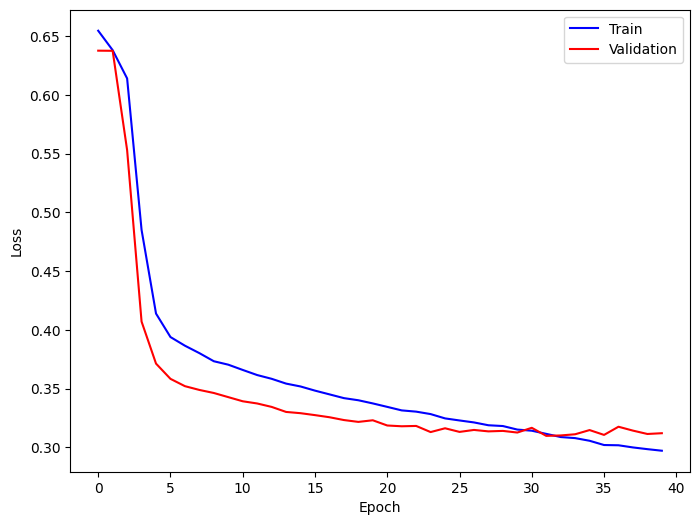

In [79]:
plot_hist(train_history, val_history)

In [80]:
y_pred_raw = model.predict(X_test)

softmax = StableSoftmax()
y_pred_proba = softmax(y_pred_raw)
y_pred = np.argmax(y_pred_proba, axis=1)

In [83]:
# Eval model on test
show_metrics(y_test, y_pred)

Metrics by classes
Accuracy: 0.8615
Precision: 0.8760; 0.8276
Recall: 0.9224; 0.7405
F1-Score: 0.8986; 0.7816


Actual     
               0    1
Predict 0   2211  313
        1    186  893

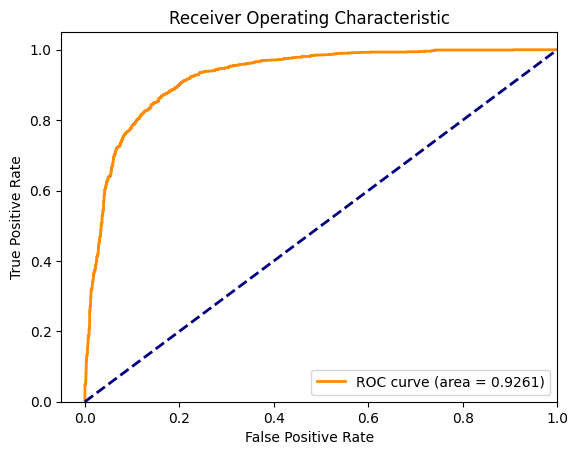

In [84]:
roc_auc, fpr, tpr = roc_curve(y_test, y_pred_proba[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()